# Data Ingestion

In [1]:
import pandas as pd

DATA_DIRECTORY = "/Users/goyolozano/Desktop/CG Feedback/Data/"

product_usage_df = pd.read_csv(DATA_DIRECTORY + "product_usage.csv")
feedback_df = pd.read_json(DATA_DIRECTORY + "feedback.jsonl", lines=True)

In [2]:
print("product_usage:", product_usage_df.shape)
print("feedback:", feedback_df.shape)
print(f"Unique customer IDs in feedback_df: {feedback_df['customer_id'].nunique()}")
print(f"Unique customer IDs in product_usage_df: {product_usage_df['customer_id'].nunique()}")
print(f"Number of matching customer IDs found in both files: {len(set(feedback_df['customer_id']) & set(product_usage_df['customer_id']))}")

product_usage: (709, 7)
feedback: (260, 4)
Unique customer IDs in feedback_df: 234
Unique customer IDs in product_usage_df: 709
Number of matching customer IDs found in both files: 39


In [3]:
# %%
# LLM Set Up
import google.generativeai as genai
import os
from dotenv import load_dotenv

# This is a robust way to handle the file path regardless of where you are running the notebook.
dotenv_path = os.path.join("/Users/goyolozano/Desktop/CG Feedback", '.env')

# Load the environment variables from the specified path
load_dotenv(dotenv_path=dotenv_path)

# Access the API key
GOOGLE_API_KEY = os.environ.get("GOOGLE_API_KEY")

# Check if the key was loaded correctly
if GOOGLE_API_KEY is None:
    print("Warning: GOOGLE_API_KEY not found at the specified path.")
else:
    print("API key loaded successfully.")

GEMINI_MODEL_NAME = "gemini-2.5-flash-lite"

genai.configure(api_key=GOOGLE_API_KEY)
gemini_model_instance = genai.GenerativeModel(GEMINI_MODEL_NAME)

API key loaded successfully.


/Users/goyolozano/Desktop/CG Feedback/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Theme Mining


In [4]:
feedback_analysis_df = feedback_df.copy()

#  Assigning a concise theme (≤5 words) to each feedback message
PROMPT_TEMPLATE = """
[Role/Persona]
You are a highly precise AI analyst specializing in customer feedback analytics for fintech applications. You process user messages with a focus on accuracy and strict adherence to formatting rules.

[Context]
You will be given a single customer feedback message from a user of a cash advance app.

[Task]
Your goal is to perform two actions: first, precisely categorize the user's sentiment, and second, distill the core topic of the message into a concise summary.

---
[Sentiment Analysis Rules]
1.  The "sentiment" value MUST be one of these three exact strings: "Positive" or "Negative". No other values are permitted.
2.  **Positive**: Use for messages expressing satisfaction, good customer service, and overall experience.
3.  **Negative**: Use for messages expressing frustration, confusion, disappointment, bugs, or problems.

---
[Theme Generation Rules]
1.  The "theme" value MUST be a concise summary of the message's core topic.
2.  The theme MUST be 5 words or less.
3.  Focus on the root cause or primary subject. For example, for "Why can't I link my Chime account?", the theme should be "Chime account linking issue", not "User has a question".

---
[Examples]
-   **Input**: "The approval rules are unclear—got rejected again."
    **Output**: {{"theme": "Unclear advance approval rules", "sentiment": "Negative"}}

-   **Input**: "Loving the instant access to cash—thanks!"
    **Output**: {{"theme": "Appreciation for instant cash", "sentiment": "Positive"}}

---
[Output Format]
Your response MUST be a single, valid JSON object and nothing else. Do not wrap it in markdown or add any introductory text. The JSON object must contain these two keys:
1.  "theme": A string summarizing the core topic.
2.  "sentiment": A string indicating the sentiment.

[User Message]
{message}
"""

import json
import time
from tqdm.auto import tqdm
from concurrent import futures

# --- Caching and API Call Function ---
# A simple dictionary to cache results for duplicate messages
analysis_cache = {}

def analyze_feedback_with_cache(message):
    """
    Sends a message to the Gemini API, using a cache to avoid re-processing duplicates.
    """
    # 1. Check cache first
    if message in analysis_cache:
        return analysis_cache[message]
    
    # 2. If not in cache, call the API
    prompt = PROMPT_TEMPLATE.format(message=message)
    try:
        # Use the correctly named model instance
        response = gemini_model_instance.generate_content(prompt)
        cleaned_response = response.text.strip().replace("```json", "").replace("```", "").strip()
        result = json.loads(cleaned_response)
        
        theme = result.get("theme", "Error: No Theme")
        sentiment = result.get("sentiment", "Error: No Sentiment")
        
        # 3. Store result in cache before returning
        analysis_cache[message] = (theme, sentiment)
        return theme, sentiment
        
    except (json.JSONDecodeError, Exception) as e:
        print(f"Error processing message: '{message[:50]}...'. Error: {e}")
        return "Error: Parsing Failed", "Error: Parsing Failed"

# --- Process all feedback messages concurrently ---
# We only need to process the unique messages to leverage the cache effectively
unique_messages = feedback_analysis_df['message'].unique().tolist()
results_map = {}

# Use ThreadPoolExecutor to run API calls in parallel
# max_workers is now set to 30 as requested
MAX_WORKERS = 30
print(f"Starting concurrent analysis of {len(unique_messages)} unique messages with {MAX_WORKERS} workers...")

with futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    # Submit all unique messages to the executor
    future_to_message = {executor.submit(analyze_feedback_with_cache, msg): msg for msg in unique_messages}
    
    # Use tqdm to create a progress bar as futures complete
    for future in tqdm(futures.as_completed(future_to_message), total=len(unique_messages)):
        message = future_to_message[future]
        try:
            # Get the result from the future
            theme, sentiment = future.result()
            results_map[message] = (theme, sentiment)
        except Exception as exc:
            print(f"'{message}' generated an exception: {exc}")
            results_map[message] = ("Error: Exception", "Error: Exception")

print("Concurrent analysis complete.")

# --- Map the results back to the original DataFrame ---
# This ensures that all rows, including duplicates, get the correct analysis
mapped_results = feedback_analysis_df['message'].map(results_map)

# Create the new columns directly from the mapped tuples to avoid the join error
# This is a more robust method for adding the columns in a notebook.
feedback_analysis_df['concise_theme'] = mapped_results.apply(lambda x: x[0] if isinstance(x, tuple) else 'Error')
feedback_analysis_df['sentiment'] = mapped_results.apply(lambda x: x[1] if isinstance(x, tuple) else 'Error')

# --- Display the first 10 rows to verify the new columns ---
print("\n--- Feedback Analysis with Theme and Sentiment (First 10 Rows) ---")
display(feedback_analysis_df.head(10))



I0000 00:00:1757084394.384731 8110705 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


Starting concurrent analysis of 51 unique messages with 30 workers...


100%|██████████| 51/51 [00:00<00:00, 52.65it/s]

Concurrent analysis complete.

--- Feedback Analysis with Theme and Sentiment (First 10 Rows) ---


,id,customer_id,created_at,message,concise_theme,sentiment
0,87485d65-56d3-4cd5-9667-5421ef7607a0,cust_00056,2025-06-14 02:39:55+00:00,Why does the selfie step repeat?,Selfie verification repeating issue,Negative
1,d704af82-a1cf-4dce-9685-bb53a818cf8c,cust_00781,2025-06-14 07:32:43+00:00,Customer support was super helpful.,Helpful customer support,Positive
2,696393b6-b3db-4622-8841-67f49ca27a6a,cust_00269,2025-06-14 08:14:43+00:00,The approval rules are unclear—got rejected ag...,Unclear advance approval rules,Negative
3,a4f49e7a-88ce-45aa-ae45-af6a2773967a,cust_00225,2025-06-14 12:54:13+00:00,Loving the instant access to cash—thanks!,Appreciation for instant cash,Positive
4,39984937-8702-41c4-8dcb-a619e8474d34,cust_00694,2025-06-14 21:52:51+00:00,The new UI looks clean and easy to use.,New UI ease of use,Positive
5,14040265-b6de-42e0-bd78-02c017fa57cd,cust_00855,2025-06-14 22:30:55+00:00,Chime connection keeps timing out during link.,Chime connection timeout issue,Negative
6,f5081c3c-6a2a-4343-b6f1-a474182cfeaf,cust_00498,2025-06-15 10:22:17+00:00,"Great app, the budgeting tips helped me.",Appreciation for budgeting tips,Positive
7,4a094a5f-5497-40fc-8114-c1069df29959,cust_00686,2025-06-15 23:28:19+00:00,"My ID got rejected, but the image was clear.",ID rejected despite clear image,Negative
8,314d119a-fe72-4435-93fb-57496ca262c5,cust_00787,2025-06-16 08:53:55+00:00,Chime won’t connect even after multiple tries.,Chime account connection failure,Negative
9,c22b094e-4396-4e3d-9be7-5de3a2192d72,cust_00625,2025-06-16 10:17:41+00:00,Why does the selfie step repeat?,Selfie verification repeating issue,Negative


# Consolidating into 5 recurring themes

In [5]:
import pandas as pd
import json
import os
from tqdm.auto import tqdm
from concurrent import futures

# This code assumes 'feedback_analysis_df' and 'gemini_model_instance' are available.

# --- Step 1: Extract and Count Unique Themes ---
valid_themes_df = feedback_analysis_df[~feedback_analysis_df['concise_theme'].str.contains("Error", na=False)]
theme_list_for_prompt = valid_themes_df['concise_theme'].unique().tolist()

print("--- Unique Themes Identified for Consolidation ---")
print(f"Found {len(theme_list_for_prompt)} unique themes to categorize.")

CONSOLIDATION_PROMPT_TEMPLATE = """
[Role/Persona]
You are a meticulous and expert data analyst AI. Your primary strength is identifying meaningful, high-level patterns from raw text data and grouping them with extreme precision.

[Context]
You will be given a JSON list of raw, specific themes that were extracted from customer feedback messages in a fintech app. Many of these themes are semantically similar or refer to the same core user issue, just phrased differently.

[Task]
Your task is to analyze the entire list of themes and consolidate them into exactly 5 distinct, high-level categories. The goal is to create meaningful groups that represent the most significant recurring issues or topics in the feedback.

[Input Data]
Here is the list of themes you must categorize:
{theme_list}

---
[CRITICAL RULES]
1.  **Exactly 5 Categories**: The final output MUST contain exactly 5 theme categories. No more, no less.
2.  **Complete Coverage**: EVERY single theme from the input list must be placed into one of the 5 categories. Do not omit any themes.
3.  **No Vague Categories**: You are strictly forbidden from creating generic, catch-all categories like "Miscellaneous," "Other," "General Feedback," or "User Issues." Each category name must be specific and actionable.
4.  **Concise Naming**: Each category name must be concise and descriptive, with a maximum of 4 words.

---
[Good vs. Bad Example]
-   **GOOD Category Name**: "Advance Approval & Rejection" (This is specific and actionable).
-   **BAD Category Name**: "User Problems" (This is too generic and not useful).

---
[Output Format]
Your response MUST be a single, valid JSON object and nothing else. Do not wrap it in markdown backticks or add any introductory text like "Here is the JSON object:".

The JSON object must have a single key "theme_categories".
The value of this key must be a list of 5 JSON objects.
Each object in the list must contain two keys:
1.  "category_name": A string for the high-level category name you created (e.g., "Technical & Performance Problems").
2.  "included_themes": A list of all the original theme strings that belong to this category.

[Example of Final Output Structure]
{{
  "theme_categories": [
    {{
      "category_name": "Example Category Name 1",
      "included_themes": ["raw theme a", "raw theme b", "raw theme c"]
    }},
    {{
      "category_name": "Example Category Name 2",
      "included_themes": ["raw theme d", "raw theme e"]
    }}
  ]
}}
"""

# --- Step 3: Call LLM (with Caching) to Consolidate Themes ---
CACHE_FILE = "consolidation_cache.json"
consolidated_data = None

# --- CHANGED: Always clear cache at the start of the run ---
try:
    if os.path.exists(CACHE_FILE):
        os.remove(CACHE_FILE)
        print(f"Cleared cache file: {CACHE_FILE}")
except Exception as e:
    print(f"Warning: could not remove cache file '{CACHE_FILE}': {e}")

try:
    # After clearing, there is no cache to load; proceed to call the LLM.
    print("\nSending themes to LLM for consolidation...")
    consolidation_prompt = CONSOLIDATION_PROMPT_TEMPLATE.format(
        theme_list=json.dumps(theme_list_for_prompt)
    )

    consolidation_response = gemini_model_instance.generate_content(consolidation_prompt)
    cleaned_consolidation_response = (
        consolidation_response.text.strip()
        .replace("```json", "")
        .replace("```", "")
        .strip()
    )

    consolidated_data = json.loads(cleaned_consolidation_response)
    print("Successfully received and parsed consolidated themes from LLM.")

    # Recreate a fresh cache (optional; will be cleared on next run anyway)
    with open(CACHE_FILE, 'w') as f:
        json.dump(consolidated_data, f, indent=2)
    print(f"Result saved to cache file: {CACHE_FILE}")

    # --- Step 4: Create the Mapping Dictionary ---
    theme_to_category_map = {}
    for category in consolidated_data.get("theme_categories", []):
        category_name = category.get("category_name")
        included_themes = category.get("included_themes", [])
        if category_name:
            for theme in included_themes:
                theme_to_category_map[theme] = category_name

    # --- Step 5: Apply the Mapping ---
    feedback_analysis_df['theme_category'] = feedback_analysis_df['concise_theme'].map(theme_to_category_map)

    print("\n--- Theme Consolidation Complete ---")
    print(feedback_analysis_df['theme_category'].value_counts())

    print("\n--- DataFrame with Consolidated Theme Category (First 10 Rows) ---")
    display(feedback_analysis_df.head(10))

except (json.JSONDecodeError, Exception) as e:
    print(f"\nAn error occurred during theme consolidation: {e}")
    print("Could not create the 'theme_category' column. Please check the LLM response.")


--- Unique Themes Identified for Consolidation ---
Found 40 unique themes to categorize.

Sending themes to LLM for consolidation...
Successfully received and parsed consolidated themes from LLM.
Result saved to cache file: consolidation_cache.json

--- Theme Consolidation Complete ---
theme_category
Notifications & Positive Feedback    69
Account & Connection Errors          63
Advance Product Functionality        47
Verification Issues                  46
App Performance & Stability          35
Name: count, dtype: int64

--- DataFrame with Consolidated Theme Category (First 10 Rows) ---


,id,customer_id,created_at,message,concise_theme,sentiment,theme_category
0,87485d65-56d3-4cd5-9667-5421ef7607a0,cust_00056,2025-06-14 02:39:55+00:00,Why does the selfie step repeat?,Selfie verification repeating issue,Negative,Verification Issues
1,d704af82-a1cf-4dce-9685-bb53a818cf8c,cust_00781,2025-06-14 07:32:43+00:00,Customer support was super helpful.,Helpful customer support,Positive,Notifications & Positive Feedback
2,696393b6-b3db-4622-8841-67f49ca27a6a,cust_00269,2025-06-14 08:14:43+00:00,The approval rules are unclear—got rejected ag...,Unclear advance approval rules,Negative,Advance Product Functionality
3,a4f49e7a-88ce-45aa-ae45-af6a2773967a,cust_00225,2025-06-14 12:54:13+00:00,Loving the instant access to cash—thanks!,Appreciation for instant cash,Positive,Notifications & Positive Feedback
4,39984937-8702-41c4-8dcb-a619e8474d34,cust_00694,2025-06-14 21:52:51+00:00,The new UI looks clean and easy to use.,New UI ease of use,Positive,Notifications & Positive Feedback
5,14040265-b6de-42e0-bd78-02c017fa57cd,cust_00855,2025-06-14 22:30:55+00:00,Chime connection keeps timing out during link.,Chime connection timeout issue,Negative,Account & Connection Errors
6,f5081c3c-6a2a-4343-b6f1-a474182cfeaf,cust_00498,2025-06-15 10:22:17+00:00,"Great app, the budgeting tips helped me.",Appreciation for budgeting tips,Positive,Notifications & Positive Feedback
7,4a094a5f-5497-40fc-8114-c1069df29959,cust_00686,2025-06-15 23:28:19+00:00,"My ID got rejected, but the image was clear.",ID rejected despite clear image,Negative,Verification Issues
8,314d119a-fe72-4435-93fb-57496ca262c5,cust_00787,2025-06-16 08:53:55+00:00,Chime won’t connect even after multiple tries.,Chime account connection failure,Negative,Account & Connection Errors
9,c22b094e-4396-4e3d-9be7-5de3a2192d72,cust_00625,2025-06-16 10:17:41+00:00,Why does the selfie step repeat?,Selfie verification repeating issue,Negative,Verification Issues


# The Trends

--- Generating Styled Weekly Trend Chart ---


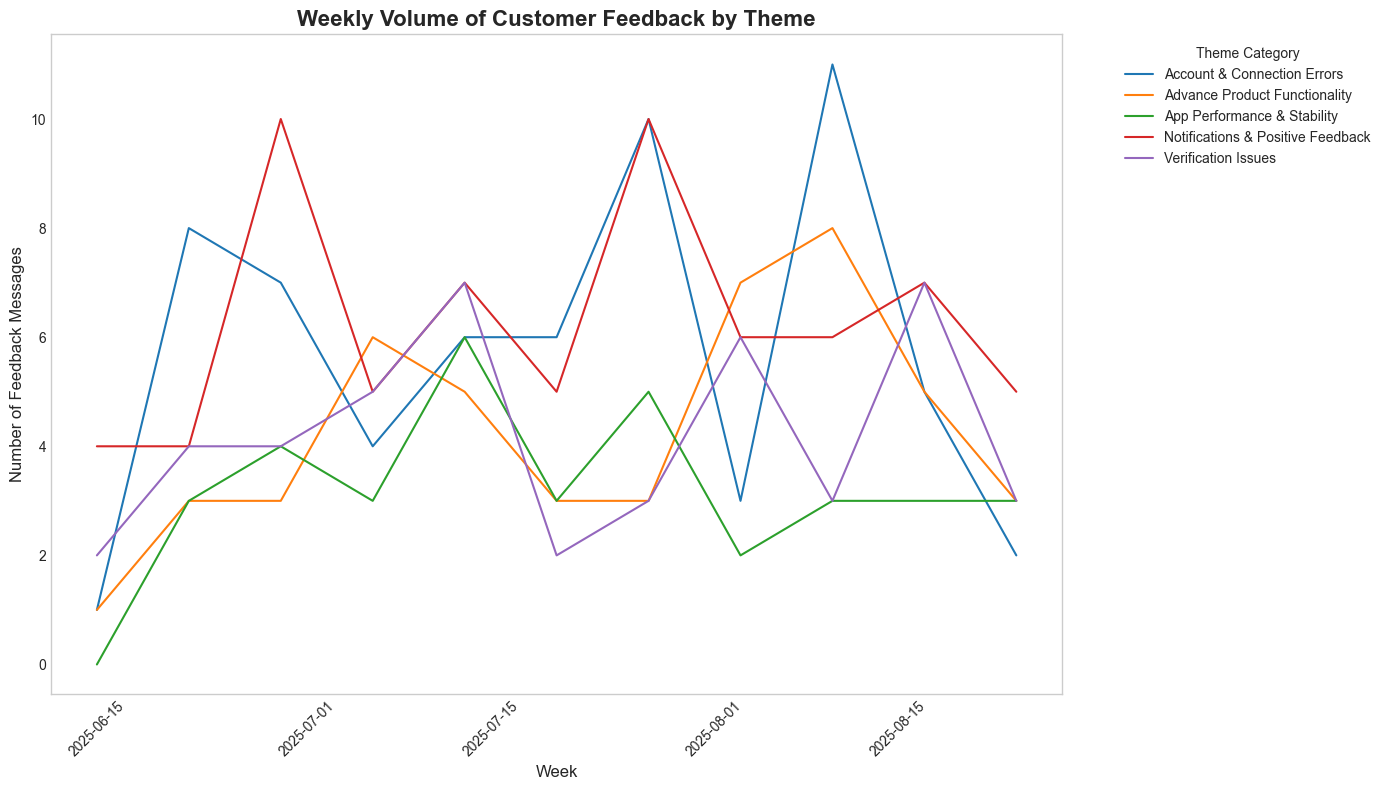


--- Monthly Summary of Feedback Volume (All Sentiments) ---


theme_category,Account & Connection Errors,Advance Product Functionality,App Performance & Stability,Notifications & Positive Feedback,Verification Issues
created_at,,,,,
2025-06-30 00:00:00+00:00,16,8,7,18,10
2025-07-31 00:00:00+00:00,29,21,18,31,20
2025-08-31 00:00:00+00:00,18,18,10,20,16


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# This code assumes 'feedback_analysis_df' from the previous chunk is available.

# --- Step 1: Prepare Data for Plotting ---
# Make a copy to ensure the original analysis DataFrame is not modified
plot_df = feedback_analysis_df.copy()

# Ensure the 'created_at' column is in datetime format and set it as the index
plot_df['created_at'] = pd.to_datetime(plot_df['created_at'])
plot_df.set_index('created_at', inplace=True)

# Filter out 'Other' and error categories for a cleaner trend plot
main_themes = [theme for theme in plot_df['theme_category'].unique() if theme not in ['Other', 'Error']]
plot_df_filtered = plot_df[plot_df['theme_category'].isin(main_themes)]

# --- Step 2: Resample Data for Weekly Trend Analysis ---
# Use pd.Grouper for modern, explicit resampling
weekly_trends = plot_df_filtered.groupby([
    pd.Grouper(freq='W'), 
    'theme_category'
]).size().unstack('theme_category').fillna(0)


# --- Step 3: Plot the Weekly Trends ---
print("--- Generating Styled Weekly Trend Chart ---")
# Set a cleaner plot style without grid lines
sns.set_style("ticks")
plt.style.use("seaborn-v0_8-whitegrid") 
fig, ax = plt.subplots(figsize=(14, 8))

# Plot each theme as a separate line using a loop, without markers
for theme in weekly_trends.columns:
    ax.plot(weekly_trends.index, weekly_trends[theme], linestyle='-', label=theme)

# Formatting the Plot
ax.set_title('Weekly Volume of Customer Feedback by Theme', fontsize=16, weight='bold')
ax.set_xlabel('Week', fontsize=12)
ax.set_ylabel('Number of Feedback Messages', fontsize=12)
ax.grid(False) # Explicitly turn off the grid

ax.legend(title='Theme Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# --- Step 4: Generate a Monthly Summary Table ---
print("\n--- Monthly Summary of Feedback Volume (All Sentiments) ---")
monthly_summary = plot_df_filtered.groupby([pd.Grouper(freq='ME'), 'theme_category']).size().unstack('theme_category').fillna(0)
display(monthly_summary)



# Trend Summary

In [7]:
import json

# --- Step 1: Define the Prompt for the LLM ---
# We will feed the data as string tables directly into the prompt.
SUMMARY_PROMPT_TEMPLATE = """
[Role/Persona]
You are a senior data analyst at a financial technology company.

[Context]
You have been given two data tables summarizing customer feedback trends for our app. The first table shows the number of feedback messages received each week for our top 5 recurring themes. The second table shows the same data aggregated by month. The data covers the period from mid-June to late-August 2025.

[Task]
Your goal is to write a short, professional summary of the key insights from this data. Focus on the most significant trends. Mention which themes are most frequent overall and if any themes show a noticeable increase or decrease over the period.

[Data]
Weekly Feedback Volume:
{weekly_data}

Monthly Feedback Volume:
{monthly_data}

[Output Format]
Provide the summary as a professional paragraph, consisting of 2-3 distinct sentences. Do not add any extra titles or formatting.
"""

# --- Step 2: Format the Data and the Prompt ---
# Convert the DataFrames to a string format that's easy for the LLM to read
weekly_data_str = weekly_trends.to_string()
monthly_data_str = monthly_summary.to_string()

# Populate the prompt with the data
summary_prompt = SUMMARY_PROMPT_TEMPLATE.format(
    weekly_data=weekly_data_str,
    monthly_data=monthly_data_str
)

# --- Step 3: Call the LLM to Generate the Summary ---
print("--- Generating AI-Powered Summary of Trends ---")
try:
    # Generate the summary
    summary_response = gemini_model_instance.generate_content(summary_prompt)
    
    # --- Step 4: Display the Summary ---
    print("\n--- Summary of Feedback Trends ---")
    print(summary_response.text)

except Exception as e:
    print(f"\nAn error occurred while generating the summary: {e}")



--- Generating AI-Powered Summary of Trends ---

--- Summary of Feedback Trends ---
Analysis of customer feedback from mid-June to late-August 2025 reveals that "Notifications & Positive Feedback" and "Account & Connection Errors" were the most frequent themes overall, with significant peaks in July for both. While "Account & Connection Errors" showed a notable increase from June to July, it declined in August, whereas "Advance Product Functionality" experienced a consistent rise throughout the period before leveling off in August.


# Anomalyz Detection

--- Preparing multi-dimensional feedback analysis ---
Analyzing 11 weeks of data across 5 themes

--- Performing Multi-Method Anomaly Detection ---

✓ Anomaly detection complete. Found 1 high-confidence anomaly(ies)

ANOMALY DETECTION REPORT

1. Theme: 'App Performance & Stability'
   Date: Week of 2025-07-13
   Negative feedback: 6 (average: 3.2)
   Total feedback: 6
   Negative ratio: 100.0%
   Severity: 1.83 | Confidence: 0.5
   Detection methods: IQR, Z-score

--- Generating Enhanced Anomaly Visualization ---


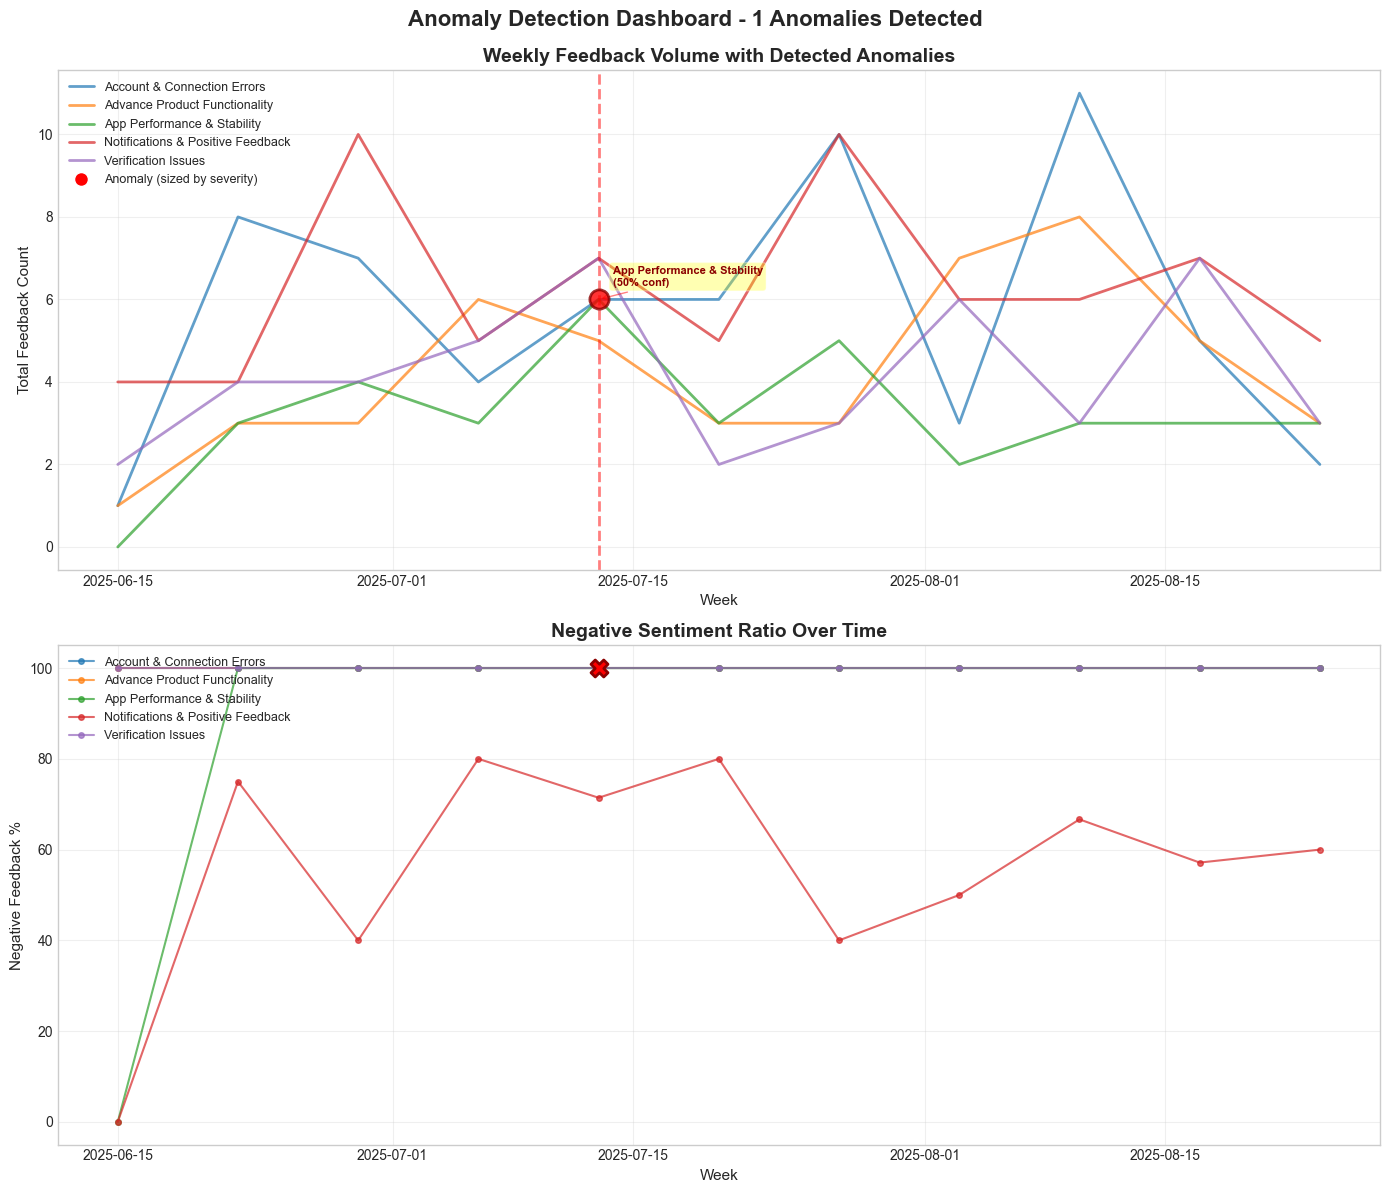


--- Statistical Summary ---


,Theme,Mean,Std Dev,CV,Max,Weeks >0
theme_category,,,,,,
Account & Connection Errors,Account & Connection Errors,5.73,3.17,0.55,11.0,11
Advance Product Functionality,Advance Product Functionality,4.27,2.10,0.49,8.0,11
Verification Issues,Verification Issues,4.18,1.83,0.44,7.0,11
Notifications & Positive Feedback,Notifications & Positive Feedback,3.45,1.29,0.37,5.0,10
App Performance & Stability,App Performance & Stability,3.18,1.54,0.48,6.0,10


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import numpy as np
from scipy import stats

# --- Step 1: Prepare Data for Analysis ---
analysis_df = feedback_analysis_df.copy()
analysis_df['created_at'] = pd.to_datetime(analysis_df['created_at'])
analysis_df.set_index('created_at', inplace=True)

# Filter out 'Other' and error categories
main_themes = [theme for theme in analysis_df['theme_category'].unique() 
               if theme not in ['Other', 'Error', None]]
analysis_df = analysis_df[analysis_df['theme_category'].isin(main_themes)]

# --- Step 2: Create Multiple Views of the Data ---
print("--- Preparing multi-dimensional feedback analysis ---")

# Negative feedback by week
negative_feedback_df = analysis_df[analysis_df['sentiment'] == 'Negative']
weekly_negative_trends = negative_feedback_df.groupby([
    pd.Grouper(freq='W'), 
    'theme_category'
]).size().unstack('theme_category').fillna(0)

# Total feedback by week (for proportional analysis)
weekly_total_trends = analysis_df.groupby([
    pd.Grouper(freq='W'),
    'theme_category'
]).size().unstack('theme_category').fillna(0)

# Calculate negative sentiment ratio
weekly_negative_ratio = weekly_negative_trends.div(weekly_total_trends.replace(0, np.nan))

print(f"Analyzing {len(weekly_negative_trends)} weeks of data across {len(main_themes)} themes")

# --- Step 3: Enhanced Anomaly Detection ---
print("\n--- Performing Multi-Method Anomaly Detection ---")

def detect_anomalies_iqr(data, multiplier=1.5):
    """Detect anomalies using IQR method (robust to outliers)"""
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Only flag upper anomalies (spikes)
    upper_bound = Q3 + multiplier * IQR
    return data[data > upper_bound], upper_bound

def detect_anomalies_mad(data, threshold=3.0):
    """Detect anomalies using Median Absolute Deviation (very robust)"""
    median = data.median()
    mad = np.median(np.abs(data - median))
    
    if mad == 0:
        # Use mean absolute deviation if MAD is zero
        mad = np.mean(np.abs(data - median))
    
    if mad > 0:
        modified_z_scores = 0.6745 * (data - median) / mad
        return data[modified_z_scores > threshold], median + threshold * mad / 0.6745
    return pd.Series(), np.nan

def detect_anomalies_zscore(data, threshold=2.0):
    """Detect anomalies using z-score (traditional method)"""
    mean = data.mean()
    std = data.std()
    
    if std > 0:
        z_scores = (data - mean) / std
        upper_threshold = mean + threshold * std
        return data[z_scores > threshold], upper_threshold
    return pd.Series(), np.nan

# Store all detected anomalies with confidence scores
anomalies = []
anomaly_methods = {}  # Track which methods detected each anomaly

MIN_WEEKS = 6  # Minimum weeks of data needed for reliable detection
MIN_VARIATION_CV = 0.2  # Minimum coefficient of variation to consider

for theme in weekly_negative_trends.columns:
    theme_data = weekly_negative_trends[theme]
    theme_total = weekly_total_trends[theme]
    theme_ratio = weekly_negative_ratio[theme].dropna()
    
    # Skip themes with insufficient data
    if len(theme_data[theme_data > 0]) < MIN_WEEKS:
        print(f"  Skipping '{theme}': insufficient data points ({len(theme_data[theme_data > 0])} weeks)")
        continue
    
    # Check if there's meaningful variation
    if theme_data.mean() > 0:
        cv = theme_data.std() / theme_data.mean()
        if cv < MIN_VARIATION_CV:
            print(f"  Skipping '{theme}': low variation (CV={cv:.2f})")
            continue
    
    # Method 1: IQR-based detection (most robust)
    iqr_anomalies, iqr_threshold = detect_anomalies_iqr(theme_data, multiplier=1.5)
    
    # Method 2: MAD-based detection (robust alternative)
    mad_anomalies, mad_threshold = detect_anomalies_mad(theme_data, threshold=2.5)
    
    # Method 3: Z-score detection (for comparison)
    zscore_anomalies, zscore_threshold = detect_anomalies_zscore(theme_data, threshold=1.8)
    
    # Method 4: Proportional spike detection
    ratio_anomalies, ratio_threshold = detect_anomalies_iqr(theme_ratio, multiplier=1.5)
    
    # Combine methods - require at least 2 methods to agree
    all_weeks = set()
    all_weeks.update(iqr_anomalies.index)
    all_weeks.update(mad_anomalies.index)
    all_weeks.update(zscore_anomalies.index)
    
    for week in all_weeks:
        detection_count = 0
        methods_detected = []
        
        if week in iqr_anomalies.index:
            detection_count += 1
            methods_detected.append("IQR")
        if week in mad_anomalies.index:
            detection_count += 1
            methods_detected.append("MAD")
        if week in zscore_anomalies.index:
            detection_count += 1
            methods_detected.append("Z-score")
        if week in ratio_anomalies.index:
            detection_count += 1
            methods_detected.append("Ratio")
        
        # Require at least 2 methods to agree (or just ratio if it's extreme)
        confidence = detection_count / 4.0
        
        if detection_count >= 2 or (week in ratio_anomalies.index and theme_ratio[week] > 0.8):
            # Calculate severity score
            severity = (theme_data[week] - theme_data.mean()) / (theme_data.std() + 0.001)
            
            anomalies.append({
                "theme": theme,
                "week_timestamp": week,
                "count": int(theme_data[week]),
                "total_feedback": int(theme_total[week]),
                "negative_ratio": float(theme_ratio[week]) if week in theme_ratio.index else None,
                "mean_count": round(theme_data.mean(), 1),
                "methods_detected": methods_detected,
                "confidence": round(confidence, 2),
                "severity": round(severity, 2),
                "iqr_threshold": round(iqr_threshold, 1) if not pd.isna(iqr_threshold) else None
            })

# Sort anomalies by severity
anomalies = sorted(anomalies, key=lambda x: x['severity'], reverse=True)

print(f"\n✓ Anomaly detection complete. Found {len(anomalies)} high-confidence anomaly(ies)")

# --- Step 4: Enhanced Anomaly Report ---
if anomalies:
    print("\n" + "="*60)
    print("ANOMALY DETECTION REPORT")
    print("="*60)
    
    for i, anomaly in enumerate(anomalies, 1):
        week_str = anomaly['week_timestamp'].strftime('%Y-%m-%d')
        print(f"\n{i}. Theme: '{anomaly['theme']}'")
        print(f"   Date: Week of {week_str}")
        print(f"   Negative feedback: {anomaly['count']} (average: {anomaly['mean_count']})")
        print(f"   Total feedback: {anomaly['total_feedback']}")
        
        if anomaly['negative_ratio']:
            print(f"   Negative ratio: {anomaly['negative_ratio']:.1%}")
        
        print(f"   Severity: {anomaly['severity']} | Confidence: {anomaly['confidence']}")
        print(f"   Detection methods: {', '.join(anomaly['methods_detected'])}")
        
        # Add contextual insight
        if anomaly['severity'] > 3:
            print("   ⚠️ CRITICAL: This represents an extreme deviation")
        elif anomaly['severity'] > 2:
            print("   ⚠️ HIGH: Significant spike requiring attention")
else:
    print("\n✓ No statistically significant anomalies detected in the data")

# --- Step 5: Enhanced Visualization ---
print("\n--- Generating Enhanced Anomaly Visualization ---")

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Top plot: Absolute counts with anomalies
for theme in weekly_total_trends.columns:
    ax1.plot(weekly_total_trends.index, weekly_total_trends[theme], 
            linestyle='-', alpha=0.7, label=theme, linewidth=2)

# Add anomaly markers
if anomalies:
    # Group anomalies by week for cleaner visualization
    anomaly_weeks = {}
    for anomaly in anomalies:
        week = anomaly['week_timestamp']
        if week not in anomaly_weeks:
            anomaly_weeks[week] = []
        anomaly_weeks[week].append(anomaly)
    
    for week, week_anomalies in anomaly_weeks.items():
        # Draw vertical line once per week
        ax1.axvline(x=week, color='red', linestyle='--', linewidth=2, alpha=0.5)
        
        # Plot markers for each theme with anomaly
        for anomaly in week_anomalies:
            theme = anomaly['theme']
            if week in weekly_total_trends.index and theme in weekly_total_trends.columns:
                y_pos = weekly_total_trends.loc[week, theme]
                
                # Size of marker based on severity
                marker_size = 100 + (anomaly['severity'] * 50)
                ax1.scatter(week, y_pos, color='red', s=marker_size, 
                          zorder=5, alpha=0.8, edgecolor='darkred', linewidth=2)
                
                # Add label with offset to avoid overlap
                offset = 2 + (week_anomalies.index(anomaly) * 2)
                ax1.annotate(
                    f"{theme}\n({anomaly['confidence']:.0%} conf)",
                    xy=(week, y_pos),
                    xytext=(10, offset * 5),
                    textcoords='offset points',
                    fontsize=8,
                    color='darkred',
                    fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='red', alpha=0.5)
                )

ax1.set_title('Weekly Feedback Volume with Detected Anomalies', fontsize=14, weight='bold')
ax1.set_xlabel('Week', fontsize=11)
ax1.set_ylabel('Total Feedback Count', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left', fontsize=9)

# Bottom plot: Negative sentiment ratio
for theme in weekly_negative_ratio.columns:
    ratio_data = weekly_negative_ratio[theme].fillna(0) * 100  # Convert to percentage
    ax2.plot(weekly_negative_ratio.index, ratio_data, 
            linestyle='-', marker='o', markersize=4, alpha=0.7, label=theme)

# Add anomaly markers on ratio plot
if anomalies:
    for anomaly in anomalies:
        if anomaly['negative_ratio'] is not None:
            week = anomaly['week_timestamp']
            theme = anomaly['theme']
            if week in weekly_negative_ratio.index and theme in weekly_negative_ratio.columns:
                y_pos = weekly_negative_ratio.loc[week, theme] * 100
                ax2.scatter(week, y_pos, color='red', s=150, zorder=5, 
                          marker='X', edgecolor='darkred', linewidth=2)

ax2.set_title('Negative Sentiment Ratio Over Time', fontsize=14, weight='bold')
ax2.set_xlabel('Week', fontsize=11)
ax2.set_ylabel('Negative Feedback %', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper left', fontsize=9)

# Add custom legend for anomalies
if anomalies:
    anomaly_legend = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
               markersize=10, label='Anomaly (sized by severity)'),
        Line2D([0], [0], marker='X', color='w', markerfacecolor='red', 
               markersize=10, label='High negative ratio')
    ]
    ax1.legend(handles=list(ax1.get_legend_handles_labels()[0]) + [anomaly_legend[0]], 
              loc='upper left', fontsize=9)

plt.suptitle(f'Anomaly Detection Dashboard - {len(anomalies)} Anomalies Detected', 
            fontsize=16, weight='bold', y=0.99)
plt.tight_layout()
plt.show()

# --- Step 6: Statistical Summary ---
print("\n--- Statistical Summary ---")
summary_stats = pd.DataFrame({
    'Theme': weekly_negative_trends.columns,
    'Mean': weekly_negative_trends.mean(),
    'Std Dev': weekly_negative_trends.std(),
    'CV': weekly_negative_trends.std() / weekly_negative_trends.mean(),
    'Max': weekly_negative_trends.max(),
    'Weeks >0': (weekly_negative_trends > 0).sum()
})
summary_stats = summary_stats.round(2).sort_values('Mean', ascending=False)
display(summary_stats)

# Link Feedback

In [9]:
import pandas as pd
import numpy as np



# --- Step 1: Merge Feedback and Usage Data ---
print("--- Merging feedback and product usage data using an inner join ---")
# Use an 'inner' merge to ensure we only analyze the 39 customers present in both datasets.
merged_df = pd.merge(feedback_analysis_df, product_usage_df, on='customer_id', how='inner')
print(f"Data successfully merged. Found {len(merged_df)} feedback entries with matching usage data.")

# Create the final analysis DataFrame from the merged data.
# We use .copy() to avoid SettingWithCopyWarning later.
analysis_df = merged_df.copy()

# --- Step 2: Analyze Themes by Subscription Tier ---
print("\n--- Analysis: Feedback Theme Counts by Subscription Tier ---")

# Use crosstab to create a frequency table of themes vs. subscription tiers.
# This is the clearest way to see the distribution.
tier_analysis = pd.crosstab(analysis_df['theme_category'], analysis_df['subscription_tier'])

# Display the resulting table
display(tier_analysis)

# --- Step 1: Feature Engineering - Create Spend Cohorts ---
print("--- Creating user cohorts based on spending ---")
try:
    analysis_df['spend_cohort'] = pd.qcut(
        analysis_df['total_spend'],
        q=3,
        labels=['Low Spender', 'Mid Spender', 'High Spender']
    )
    print("Spend cohorts created successfully (Low, Mid, High).")
except ValueError:
    # This is a fallback if the data distribution doesn't allow for 3 clean cuts.
    analysis_df['spend_cohort'] = pd.qcut(
        analysis_df['total_spend'],
        q=2,
        labels=['Low Spender', 'High Spender'],
        duplicates='drop' # Important for handling non-unique bin edges
    )
    print("Spend cohorts created with 2 bins (Low, High) due to data distribution.")


# --- Step 2: Analyze Themes by Spend Cohort ---
print("\n--- Analysis: Feedback Theme Counts by Spend Cohort ---")

# Use crosstab to create a frequency table of themes vs. the new spend cohorts.
spend_analysis = pd.crosstab(analysis_df['theme_category'], analysis_df['spend_cohort'])

# Display the resulting table
display(spend_analysis)



# --- Step 1: Feature Engineering - Create Approval Ratio and Cohorts ---
print("--- Creating user cohorts based on advance approval ratio ---")

# a) Calculate the approval ratio
# We handle division by zero (when attempts are 0) by filling the resulting NaN with 0.
analysis_df['approval_ratio'] = (analysis_df['advance_approvals_30d'] / analysis_df['advance_attempts_30d']).fillna(0)

# b) Create cohorts using pd.cut for defined bins
# These bins represent meaningful segments: users who get no approvals, some, or most.
bins = [-0.1, 0.1, 0.5, 1.01]  # Bins for: 0%, >0% to 50%, and >50% to 100%
labels = ['Low (0%)', 'Mid (1-50%)', 'High (>50%)']
analysis_df['approval_ratio_cohort'] = pd.cut(analysis_df['approval_ratio'], bins=bins, labels=labels, right=True)
print("Approval ratio cohorts created successfully (Low, Mid, High).")


# --- Step 2: Analyze Themes by Approval Ratio Cohort ---
print("\n--- Analysis: Feedback Theme Counts by Approval Ratio Cohort ---")

# Use crosstab to create a frequency table of themes vs. the new approval cohorts.
approval_analysis = pd.crosstab(analysis_df['theme_category'], analysis_df['approval_ratio_cohort'])

# Display the resulting table
display(approval_analysis)


--- Merging feedback and product usage data using an inner join ---
Data successfully merged. Found 45 feedback entries with matching usage data.

--- Analysis: Feedback Theme Counts by Subscription Tier ---


subscription_tier,free,plus,pro
theme_category,,,
Account & Connection Errors,6,3,0
Advance Product Functionality,4,4,0
App Performance & Stability,5,1,1
Notifications & Positive Feedback,8,3,0
Verification Issues,5,4,1


--- Creating user cohorts based on spending ---
Spend cohorts created successfully (Low, Mid, High).

--- Analysis: Feedback Theme Counts by Spend Cohort ---


spend_cohort,Low Spender,Mid Spender,High Spender
theme_category,,,
Account & Connection Errors,4,4,1
Advance Product Functionality,1,4,3
App Performance & Stability,2,3,2
Notifications & Positive Feedback,3,3,5
Verification Issues,5,1,4


--- Creating user cohorts based on advance approval ratio ---
Approval ratio cohorts created successfully (Low, Mid, High).

--- Analysis: Feedback Theme Counts by Approval Ratio Cohort ---


approval_ratio_cohort,Low (0%),Mid (1-50%),High (>50%)
theme_category,,,
Account & Connection Errors,8,1,0
Advance Product Functionality,4,4,0
App Performance & Stability,4,2,1
Notifications & Positive Feedback,7,4,0
Verification Issues,4,3,3


# Recommendations

In [10]:
import json
import pandas as pd
import google.generativeai as genai

generation_config = genai.types.GenerationConfig(temperature=0.1)

def prepare_llm_context(top_n_themes=3):
    """
    Dynamically synthesizes key findings from the notebook's analysis
    into a string to be used as context for the recommendation prompt.
    """
    # 1. Find the most frequent themes overall
    top_themes = feedback_analysis_df['theme_category'].value_counts().nlargest(top_n_themes).index.tolist()
    top_themes_str = ", ".join(f"'{theme}'" for theme in top_themes)

    # 2. Format the anomaly report
    anomaly_str = ""
    if anomalies:
        for anomaly in anomalies:
            week_str = anomaly['week_timestamp'].strftime('%Y-%m-%d')
            anomaly_str += (
                f"- A significant spike in negative feedback for '{anomaly['theme']}' "
                f"occurred during the week of {week_str}.\n"
            )
    else:
        anomaly_str = "No significant anomalies in negative feedback were detected.\n"

    # 3. Dynamically find the most impacted user segments from the crosstabs
    # This identifies which user group is most affected by each of the top themes.
    segment_insights_str = ""
    for theme in top_themes:
        if theme in tier_analysis.index:
            worst_tier = tier_analysis.loc[theme].idxmax()
            segment_insights_str += (
                f"- For the theme '{theme}', the most affected subscription tier is '{worst_tier}'.\n"
            )
        if theme in spend_analysis.index:
            worst_spend = spend_analysis.loc[theme].idxmax()
            segment_insights_str += (
                f"- The user group most impacted by '{theme}' is our '{worst_spend}' cohort.\n"
            )
        if theme in approval_analysis.index:
            worst_approval = approval_analysis.loc[theme].idxmax()
            segment_insights_str += (
                f"- '{theme}' issues are most prevalent among users in the '{worst_approval}' approval ratio cohort.\n"
            )

    # 4. Assemble the final context string
    full_context = f"""
[Data Dossier: Key Analytical Findings]

1.  **Top Recurring Feedback Themes**: The most frequent customer issues are: {top_themes_str}.

2.  **Trend & Anomaly Report**:
{anomaly_str}
3.  **User Segmentation Insights**:
{segment_insights_str}
"""
    return full_context

# --- Define the Final, Bulletproof Prompt ---
RECOMMENDATION_PROMPT_TEMPLATE = """
[Role/Persona]
You are a Senior Product Manager at a high-growth fintech company. You are data-obsessed and your primary goal is to translate complex analytical findings into a prioritized, actionable product strategy.

[Context]
You have been presented with a "Data Dossier" summarizing a recent analysis of customer feedback, product usage, and sentiment trends. Your task is to use ONLY the information in this dossier to propose a strategic plan.

{data_dossier}

[Task]
Based ONLY on the data provided in the dossier, generate exactly 5 concrete, prioritized recommendations to address the identified customer issues. For each recommendation, you must provide:
1. A clear rationale that directly references a specific finding from the dossier.
2. A tangible business outcome that the recommendation aims to achieve.

[CRITICAL RULES]
- Generate EXACTLY 5 recommendations.
- Base every part of your rationale on the specific data points provided in the dossier. Do not invent information.
- Prioritize the recommendations from 1 (most urgent/impactful) to 5.

[Output Format]
Your response MUST be a single, valid JSON object and nothing else.
The JSON object should contain a single key "recommendations", which is a list of 5 JSON objects.
Each object in the list must have the following four keys:
- "priority": An integer (1-5).
- "recommendation_title": A concise, actionable title for the initiative.
- "rationale": A detailed explanation of why this action is needed, directly citing the data from the dossier.
- "business_outcome": The specific business goal this action will impact (e.g., "Reduce churn in the 'High Spender' cohort," "Improve advance approval rates for new users," "Increase user engagement on the 'free' tier.").

"""

# --- Main Execution ---
print("--- Generating Actionable Recommendations ---")
try:
    # 1. Prepare the adaptive context from our analysis
    data_dossier_context = prepare_llm_context()

    # 2. Format the final prompt
    final_prompt = RECOMMENDATION_PROMPT_TEMPLATE.format(data_dossier=data_dossier_context)

    # 3. Call the LLM
    print("Sending synthesized findings to LLM for strategic analysis...")
    response = gemini_model_instance.generate_content(
        final_prompt,
        generation_config=generation_config
    )

    # 4. Parse and Display the Recommendations
    cleaned_response = response.text.strip().replace("```json", "").replace("```", "").strip()
    recommendations_data = json.loads(cleaned_response)

    print("\n--- AI-Generated Strategic Recommendations ---")
    for rec in recommendations_data.get("recommendations", []):
        print(f"\n## Priority {rec.get('priority')}: {rec.get('recommendation_title')}")
        print(f"**Rationale:** {rec.get('rationale')}")
        print(f"**Business Outcome:** {rec.get('business_outcome')}")

except (json.JSONDecodeError, Exception) as e:
    print(f"\n--- An error occurred during recommendation generation ---")
    print(f"Error: {e}")
    print("This may be due to an issue with the LLM response format. Please check the prompt and model configuration.")



--- Generating Actionable Recommendations ---
Sending synthesized findings to LLM for strategic analysis...

--- AI-Generated Strategic Recommendations ---

## Priority 1: Investigate and Resolve 'App Performance & Stability' Spike
**Rationale:** A significant spike in negative feedback for 'App Performance & Stability' occurred during the week of 2025-07-13. Addressing this critical stability issue is paramount to prevent immediate user dissatisfaction and potential churn.
**Business Outcome:** Reduce immediate negative sentiment and prevent potential churn stemming from critical app instability.

## Priority 2: Enhance 'Notifications & Positive Feedback' for High Spenders on Free Tier
**Rationale:** The 'Notifications & Positive Feedback' theme is most prevalent among users in the 'Low (0%)' approval ratio cohort and impacts the 'High Spender' cohort specifically on the 'free' subscription tier. This suggests a critical disconnect in how valuable users on our free tier are being enga

# Explainability

In [11]:
import pandas as pd
from IPython.display import display_html

def display_side_by_side(dfs:list, titles:list):
    html_str = ''
    for df, title in zip(dfs, titles):
        # Convert each dataframe to HTML and style it
        html_str += f'<div style="display:inline-block; margin-right: 20px; vertical-align:top;">'
        html_str += f'<h3>--- Theme: {title} ---</h3>'
        html_str += df[['message', 'theme_category']].to_html()
        html_str += '</div>'
    display_html(html_str, raw=True)

print("--- Generating Explanatory Samples per Theme ---")

# Set pandas option to prevent long messages from being truncated.
pd.set_option('display.max_colwidth', None)

# Get the list of unique themes.
unique_themes = feedback_analysis_df['theme_category'].unique()

# Get the top 5 themes to display as requested.
themes_to_display = unique_themes[:5]

# Lists to store the dataframes and their titles for the side-by-side display
df_list = []
title_list = []

# Loop through each theme and generate a sampled DataFrame
for theme in themes_to_display:
    # Filter the DataFrame for the current theme
    theme_df = feedback_analysis_df[feedback_analysis_df['theme_category'] == theme]

    # Sample up to 3 messages
    sampled_df = theme_df.sample(n=min(len(theme_df), 3))

    # Add the sampled DataFrame and theme title to our lists
    df_list.append(sampled_df)
    title_list.append(theme)

# Now, call the custom function to display all the tables together
display_side_by_side(df_list, title_list)

--- Generating Explanatory Samples per Theme ---


,message,theme_category
139,Can't pass identity check; it keeps resetting.,Verification Issues
94,"My ID got rejected, but the image was clear.",Verification Issues
245,Can't pass identity check; it keeps resetting.,Verification Issues
,message,theme_category
142,Customer support was suepr helpful.,Notifications & Positive Feedback
259,"Great app, the budgeting tips helped me.",Notifications & Positive Feedback
41,The new UI looks clean and easy to use.,Notifications & Positive Feedback
,message,theme_category
81,I keep getting denied without explanation.,Advance Product Functionality
190,Please clarify the approval criteria.,Advance Product Functionality
